In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [60]:
##не юзается
def exp_func(x,y,w):
    return np.exp(-y*np.dot(w,x))

def sigmoid_func(x,y,w):
    return 1./(1. + np.exp(y*np.dot(w,x)))

def grad(X, y, w, func = sigmoid_func):
    pred_grad = np.zeros(X.shape[0])
    for i in range(len(pred_grad)):
        pred_grad[i] = func(X[i,:],y[i],w)
    pred_grad = -pred_grad*y
    return np.dot(pred_grad,X)

def grad_desc(X, y, eta = 0.001):
    X = np.hstack((np.ones((X.shape[0],1)),X))
    w = np.array([0]*X.shape[1])
    n_iter = 0
    
    while np.sum(y != np.sign(np.dot(X,w)))!=0:
        w = w - (1/X.shape[0])*eta*grad(X,y,w)
        n_iter += 1
        #eta= 1./n_iter
        print(np.sum(y != np.sign(np.dot(X,w)))/X.shape[0])
    print(n_iter)
    return w


In [11]:
#персептрон розенблатта
def perc_roz(X, y, eta = 1):
    w = np.array([0.001]*X.shape[1])
    y_pred = np.sign(np.dot(X,w))
    
    while np.sum(y_pred != y) != 0:
        index = np.where(y_pred != y)[0][0]   
        w = w + eta * X[index,:] * (y[index]-y_pred[index])
        y_pred = np.sign(np.dot(X,w))
        #print(np.sum(y_pred != y))
        
    return w
    

In [11]:
#раб. вар.
def process_input(s):
    N = int(s[0])
    y, t = [0] * N, [0] * N
    for i in range(N):
        arr = s[i+1].split()
        t[i], y[i] = arr[0], arr[1]
    return t, y

def b_auc(t, y):
    summ, counter = 0, 0
    for i in range(len(y)):
        for j in range(len(y)):
            if t[i] > t[j]:
                counter += 1
                summ += (int(y[i] > y[j]) + 0.5 * int(y[i] == y[j]))

    return summ / counter

In [145]:
#бинарный roc auc по воронцову
def binary_roc_auc(t, y, mult = False):
    classes = np.unique(t).tolist()
    classes.sort(reverse=True)
    tup_arr = list(zip(y,t))
    tup_arr.sort(reverse=True)
    auc = 0
    tpr = 0
    for i in range(len(y)):
        if tup_arr[i][1] != classes[0]:
            auc += tpr
        else:
            tpr += 1
    if mult:
        return auc
    else:
        return auc/(np.sum(t == classes[0])*np.sum(t != classes[0]))
   

In [146]:
#обобщение бинарного
def multi_roc_auc(t, y):
    
    classes = np.unique(t).tolist()
    classes.sort(reverse=True)
    classes_count = []
    for i in classes:
        classes_count.append(np.sum(t == i))
        
    auc = 0
    classes = np.array(list(zip(classes, classes_count)))
    tup_arr = list(zip(t,y))
    tup_arr.sort(reverse=True)
    tup_arr = np.array(tup_arr)
    #посчет знаменателя
    counter_const = 0
    
    for i in range(classes.shape[0] - 1):
        for j in range(i+1,classes.shape[0]):
            counter_const += classes[i][1] * classes[j][1]
            #границы для подачи на бинарный roc_auc
            b_1 = np.sum(classes[:i,1])
            b_2 = np.sum(classes[:i,1]) + classes[i,1]
            b_3 = np.sum(classes[:j,1])
            b_4 = np.sum(classes[:j,1]) + classes[j,1]
           
            auc += binary_roc_auc(np.hstack((tup_arr[b_1:b_2,0], tup_arr[b_3:b_4,0])), np.hstack((tup_arr[b_1:b_2,1], tup_arr[b_3:b_4,1])),
                                 mult=True)
    
        
    return auc/counter_const

In [25]:
X, Y = make_blobs(n_samples=1000,n_features=2, centers=3)
Y = Y*2 -1

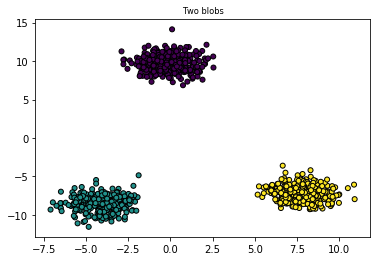

In [232]:

#plt.plot(xx, yy, 'k-')
plt.title("Two blobs", fontsize='small')
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k')
plt.show()

In [40]:
#тест перцептрона
%%time
w = perc_roz(X,Y)
print(w)
print(np.sum(Y != np.sign(np.dot(X,w))))

3112
1
0
[20.95940384 -6.83163722]
0
CPU times: user 1.84 ms, sys: 208 µs, total: 2.05 ms
Wall time: 1.5 ms


In [26]:
#тест mult_roc_auc
clf_log = LogisticRegression(C=1).fit(X,Y)

/home/dencerr/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dencerr/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [30]:
%%time
b_auc(Y,clf_log.predict_proba(X)[:,1])

CPU times: user 1.2 s, sys: 3.01 ms, total: 1.2 s
Wall time: 1.2 s


0.5100515100515101

In [27]:
%%time
multi_roc_auc(Y,clf_log.predict_proba(X)[:,1])

[[ 3.00000000e+00  4.10920223e-01]
 [ 3.00000000e+00  3.81357825e-01]
 [ 3.00000000e+00  3.61691178e-01]
 ...
 [-1.00000000e+00  1.10567990e-03]
 [-1.00000000e+00  8.88286602e-04]
 [-1.00000000e+00  7.10986883e-04]]
0 333 333 666
[[ 3.00000000e+00  4.10920223e-01]
 [ 3.00000000e+00  3.81357825e-01]
 [ 3.00000000e+00  3.61691178e-01]
 ...
 [-1.00000000e+00  1.10567990e-03]
 [-1.00000000e+00  8.88286602e-04]
 [-1.00000000e+00  7.10986883e-04]]
0 333 666 1000
[[ 3.00000000e+00  4.10920223e-01]
 [ 3.00000000e+00  3.81357825e-01]
 [ 3.00000000e+00  3.61691178e-01]
 ...
 [-1.00000000e+00  1.10567990e-03]
 [-1.00000000e+00  8.88286602e-04]
 [-1.00000000e+00  7.10986883e-04]]
333 666 666 1000
CPU times: user 7.49 ms, sys: 7.43 ms, total: 14.9 ms
Wall time: 274 ms


0.5100515100515101

In [34]:
clf_log.predict_proba(X)[:,1]

array([4.96517308e-02, 9.07698651e-02, 9.99436519e-01, 2.83971201e-03,
       9.99800649e-01, 9.98534189e-01, 9.94347559e-01, 9.99701123e-01,
       2.24576522e-01, 9.97656379e-01, 9.89905132e-01, 9.97647886e-01,
       2.54199482e-02, 4.60741939e-03, 1.79164982e-02, 9.99733733e-01,
       9.99411886e-01, 1.21576306e-01, 3.22517203e-02, 8.74474984e-02,
       1.41323232e-01, 9.99030318e-01, 9.99786805e-01, 9.98933530e-01,
       5.18765167e-02, 1.16507907e-01, 1.70782194e-01, 2.07788772e-01,
       3.52371999e-02, 5.47490294e-02, 9.37259347e-01, 5.72748558e-03,
       1.76044864e-02, 9.74589252e-02, 3.21431381e-02, 8.65856252e-02,
       9.99182183e-01, 9.99918760e-01, 9.88727180e-01, 2.11937296e-02,
       9.99038247e-01, 9.98211051e-01, 9.98637258e-01, 9.98947671e-01,
       9.99644749e-01, 4.90563285e-02, 1.01781048e-01, 1.69745321e-02,
       9.99568918e-01, 1.28198459e-02, 9.92815386e-01, 1.13120125e-03,
       2.98728755e-02, 9.97110531e-01, 3.63596650e-03, 9.97328517e-01,
      

In [46]:
import random
def RandomPermutation():
    perm = list(range(8))
    random.shuffle(perm)
    return perm

def StupidPermutation():
    partialSums = [0,1,8,35,111,285,628,1230,2191,3606,5546,
        8039,11056,14056,18242,22078,25814,29264,32281,34774,36714,
        38129,39090,39692,40035,40209,40285,40312,40319,40320]
    r = random.randint(0, partialSums[-1])
    numInv = 0
    while partialSums[numInv] < r:
        numInv += 1
    perm = list(range(8))
    for step in range(numInv):
        t1 = random.randint(0, 7)
        t2 = random.randint(0, 7)
        perm[t1], perm[t2] = perm[t2], perm[t1]
    return perm

In [47]:
def gen_perm(func = RandomPermutation, n = 2000000):
    d = dict()
    for i in range(n):
        try:
            a = func()
            d[''.join([str(i) for i in a])] += 1
        except KeyError:
            d[''.join([str(i) for i in a])] = 1
    return np.array(list(d.values()))


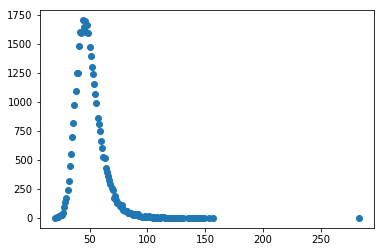

In [105]:
new_d = gen_perm(StupidPermutation)
count_dict = dict()
for i in np.unique(new_d):
    count_dict[i] = np.sum(new_d == i)
plt.scatter(count_dict.keys(), count_dict.values())

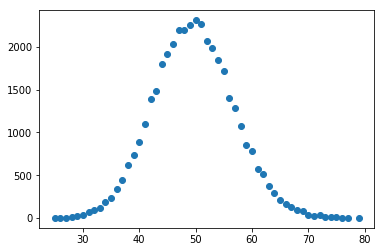

In [106]:
new_d = gen_perm(RandomPermutation)
count_dict = dict()
for i in np.unique(new_d):
    count_dict[i] = np.sum(new_d == i)
plt.scatter(count_dict.keys(), count_dict.values())

In [48]:
def get_count():
    with open('permutations.in','r') as f:
        f.readline()
        d = dict()
        for _ in range(1000):
            str_ = f.readline().replace(' ','')
            try:
                d[str_] += 1
            except KeyError:
                d[str_] = 1
        new_d = np.array(list(d.values()))
        count_dict = dict()
        for i in np.unique(new_d):
            count_dict[i] = np.sum(new_d == i)
        return count_dict

In [49]:
def gen_perm_clf(func = RandomPermutation, n = 2000000):
    d = dict()
    for i in range(n):
        try:
            a = func()
            d[''.join([str(i) for i in a])] += 1
        except KeyError:
            d[''.join([str(i) for i in a])] = 1
    return d

In [50]:
class naiv_clf:
    def __init__(self):
        self.freq_1 = None
        self.freq_2 = None
    
    def fit(self, freq_1, freq_2):
        '''freq_1 - для равном генер'''
        self.freq_1 = freq_1
        self.freq_2 = freq_2
    
    def predict(self, X):
        pred_1 = 0
        pred_2 = 0
        for key in np.unique(X):
            pred_1 += np.log(self.freq_1[key])
            pred_2 += np.log(self.freq_2[key])
        return pred_1, pred_2

In [51]:
clf = naiv_clf()
clf.fit(gen_perm_clf(),gen_perm_clf(StupidPermutation))

In [53]:
pred_1, pred_2 = clf.predict(list(gen_perm_clf(n=1000,func = StupidPermutation).keys()))
print(pred_1,pred_2,sep=' ')

3855.4205538681317 3881.467154331783


In [74]:
with open('permutations.in','r') as f:
    n = f.readline()
    res = []
    d = dict()
    for i in range(int(n)):
        for j in range(1000):
            s = f.readline().replace(' ', '')[:-1]
            d[s] = 0
        pred_1, pred_2 = clf.predict(list(d.keys()))
        res.append(0 if pred_1 > pred_2 else 1)
        d = dict()
res = np.array(res)
print(res)
res = np.argsort(res)

[0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1
 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1
 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0
 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0
 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0
 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0]


In [77]:
def write_ans(res):
    with open('answer_perm.txt', 'w') as f:
        for i in res:
            f.write(str(i)+'\n')

In [78]:
write_ans(res)

In [103]:
df = pd.read_csv('restaurants_train.txt/restaurants_train.txt',sep='\t',header=None)
df.head()

,0,1,2,3,4
0,0.5,8.154642,-1.000000,0.000552,0.000483
1,1.0,-1.000000,9.105132,0.075709,0.024765
2,0.0,7.349630,-1.000000,0.045557,0.006901
3,0.0,7.077312,-1.000000,0.000369,0.004083
4,1.0,-1.000000,-1.000000,0.002481,0.002171


In [16]:
df_0 = df[df[0]==0][[1,3]]
df_1 = df[df[0]==1][[2,4]]

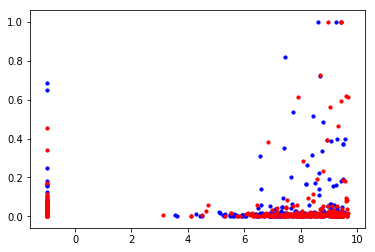

In [26]:
plt.scatter(df_0[1],df_0[3],c='blue',s=10)
plt.scatter(df_1[2],df_1[4],c='red', s=10)
plt.xlabel = 'rating'
plt.ylabel = 'distance'
plt.show()

In [29]:
tsne = TSNE()
tsne_representation = tsne.fit_transform(df[[1,2,3,4]])

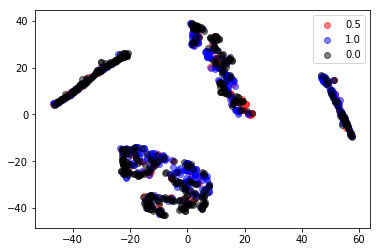

In [30]:
colors = ['red', 'blue', 'black']
for y, c in zip(set(df[0]), colors):
    plt.scatter(tsne_representation[df[0]==y, 0], 
                tsne_representation[df[0]==y, 1], c=c, alpha=0.5, label=str(y))
plt.legend()

In [112]:
new_df = pd.DataFrame()
new_df[0] = df[0]
new_df[1] = df[1]/df[2]
new_df[2] = df[3]-df[4]

df_0 = new_df[new_df[0]==0][[1,2]]
df_1 = new_df[new_df[0]==1][[1,2]]

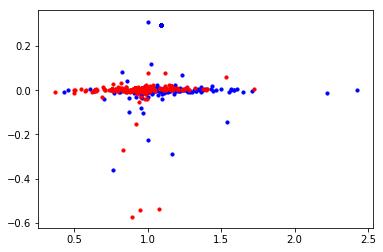

In [113]:
plt.scatter(df_0[1],df_0[2],c='blue',s=10)
plt.scatter(df_1[1],df_1[2],c='red', s=10)
plt.xlabel = 'rating'
plt.ylabel = 'distance'
plt.show()

In [104]:
d1 = df[df[1]!=-1]
d2 = df[df[2]!=-1]
df = d1.merge(d2)
d1 = df[df[3]!=1]
d2 = df[df[4]!=1]
df = d1.merge(d2)

In [24]:
s = input().split()
n = int(s[0]); m = int(s[1])
X = np.zeros((n,m))
y = np.array([0]*n)
for i in range(n):
    s = input().split()
    y[i] = s[-1]
    X[i,:] = s[:-1]
w = perc_roz(X, y, eta = 1)
print(' '.join(w.astype(str)))

KeyboardInterrupt: 

In [20]:
w = np.array([1,2,3])
print(' '.join(w.astype(str)))

1 2 3


In [156]:
def process_input():
    s = input()
    N = int(s)
    y, t = np.array([0.]*N), np.array([0.]*N)
    for i in range(N):
        s = input().split()
        t[i], y[i] = int(s[0]), float(s[1])
    return t, y

In [157]:
t, y = process_input()
print(multi_roc_auc(t,y))

2
0 0
1 1


TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
# def our_hash(s:str):
    s = s.lower().replace(' ','')
    #s = ''.join(sorted(s))
    un = sorted(list(set(s)))
    c_un = list()
    for ch in un:
        c_un.append(s.count(ch))
    new_s = list()
    for i in range(len(c_un)):
        new_s.append(str(c_un[i])+un[i])
    return hash(''.join(new_s))%10000
    
def req():
    n = int(input())
    l = list()
    counter = 0
    for i in range(n):
        s = input()
        h = our_hash(s)
        if h in l:
            continue
        else:
            l.append(h)
            counter += 1
    return counter

In [141]:
req()

3
aaasss
sssaaa
df


2

In [97]:
print(req())

3
as
as
df
2


In [102]:
a = 'asdf. ;a'
np.unique(list(a))

array([' ', '.', ';', 'a', 'd', 'f', 's'], dtype='<U1')

In [103]:
a.count('a')

2

In [104]:
sorted(a)

[' ', '.', ';', 'a', 'a', 'd', 'f', 's']

In [85]:
d = np.array([False]*100000)
d.nbytes/1024/1024

0.095367431640625

In [92]:
a = np.array([1,2,3])
a = np.append(a,3)

In [93]:
a

array([1, 2, 3, 3])

In [144]:
import numpy as np
def our_hash(s:str):
    s = s.lower().replace(' ','')
    #s = ''.join(sorted(s))
    un = sorted(list(set(s)))
    c_un = list()
    for ch in un:
        c_un.append(s.count(ch))
    new_s = list()
    for i in range(len(c_un)):
        new_s.append(str(c_un[i])+un[i])
    return hash(''.join(new_s))%100000

def req():
    n = int(input())
    l = list()
    counter = 0
    for i in range(n):
        s = input()
        if len(s)>10:
            counter += 1
            continue
        h = our_hash(s)
        if h in l:
            continue
        else:
            l.append(h)
            counter += 1
    return counter
print(req())

3
as
ssssssssssssssssssssssssssssssssssss
df
3


In [ ]:
multi_roc_auc()

In [158]:
np.unique([0.5,0.5,1])

array([0.5, 1. ])

In [2]:
def binary_roc_auc(t, y, mult = False):
    classes = np.unique(t).tolist()
    classes.sort(reverse=True)
    tup_arr = list(zip(y,t))
    tup_arr.sort(reverse=True)
    auc = 0
    tpr = 0
    for i in range(len(y)):
        if tup_arr[i][1] != classes[0]:
            auc += tpr
        else:
            tpr += 1
    if mult:
        return auc
    else:
        return auc/(np.sum(t == classes[0])*np.sum(t != classes[0]))
   

In [66]:
#обобщение бинарного
def multi_roc_auc(t, y):
    
    classes = np.unique(t).tolist()
    classes.sort(reverse=True)
    classes_count = []
    for i in classes:
        classes_count.append(np.sum(t == i))
        
    auc = 0
    classes = np.array(list(zip(classes, classes_count)))
    tup_arr = list(zip(t,y))
    tup_arr.sort(reverse=True)
    tup_arr = np.array(tup_arr)
    #посчет знаменателя
    counter_const = 0
    
    for i in range(classes.shape[0] - 1):
        for j in range(i+1,classes.shape[0]):
            counter_const += classes[i][1] * classes[j][1]   
            #границы для подачи на бинарный roc_auc
            b_1 = np.sum(classes[:i,1])
            b_2 = np.sum(classes[:i,1]) + classes[i,1]
            b_3 = np.sum(classes[:j,1])
            b_4 = np.sum(classes[:j,1]) + classes[j,1]
            auc += binary_roc_auc(np.hstack((tup_arr[int(b_1):int(b_2),0], tup_arr[int(b_3):int(b_4),0])), np.hstack((tup_arr[int(b_1):int(b_2),1], tup_arr[int(b_3):int(b_4),1])),
                                 mult=True)
    
        
    return auc/counter_const

In [64]:
def process_input():
    s = input()
    N = int(s)
    y, t = np.array([0.]*N), np.array([0.]*N)
    for i in range(N):
        s = input().split()
        t[i], y[i] = float(s[0]), float(s[1])
    return t, y

In [71]:
t, y = process_input()
#print(t,y)
print(multi_roc_auc(t,y))

3
0.5 0
0.5 1
2 0.5
0.5


In [70]:
t = np.array([0.5,1])
y = np.array([0.1,1.0])
print(multi_roc_auc(t,y))

1.0


In [52]:
b_auc(t,y)

1.0

In [16]:
#обобщение бинарного
def multi_roc_auc(t, y):
    
    classes = np.unique(t).tolist()
    classes.sort(reverse=True)
    classes_count = []
    for i in classes:
        classes_count.append(np.sum(t == i))
        
    auc = 0.
    classes = np.array(list(zip(classes, classes_count)))
    tup_arr = list(zip(t,y))
    tup_arr.sort(reverse=True)
    tup_arr = np.array(tup_arr)
    #посчет знаменателя
    counter_const = 0
    
    for i in range(classes.shape[0] - 1):
        for j in range(i+1,classes.shape[0]):
            counter_const += classes[i][1] * classes[j][1]   
            #границы для подачи на бинарный roc_auc
            b_1 = np.sum(classes[:i,1])
            b_2 = np.sum(classes[:i,1]) + classes[i,1]
            b_3 = np.sum(classes[:j,1])
            b_4 = np.sum(classes[:j,1]) + classes[j,1]
            auc += binary_roc_auc(np.hstack((tup_arr[int(b_1):int(b_2),0], tup_arr[int(b_3):int(b_4),0])), np.hstack((tup_arr[int(b_1):int(b_2),1], tup_arr[int(b_3):int(b_4),1])),
                                 mult=True)
    
        
    return auc/counter_const

def binary_roc_auc(t, y, mult = False):
    classes = np.unique(t).tolist()
    classes.sort(reverse=True)
    tup_arr = list(zip(y,t))
    tup_arr.sort(reverse=True)
    auc = 0.
    tpr = 0.
    for i in range(len(y)):
        if tup_arr[i][1] != classes[0]:
            auc += tpr
        else:
            tpr += 1
    if mult:
        return auc
    else:
        return auc/(np.sum(t == classes[0])*np.sum(t != classes[0]))

def process_input():
    s = input()
    N = int(s)
    y, t = np.array([0.]*N), np.array([0.]*N)
    for i in range(N):
        s = input().split()
        t[i], y[i] = float(s[0]), float(s[1])
    return t, y

t, y = process_input()
#print(t,y)
print(str("%.8f" % (multi_roc_auc(t,y))))

2
0.1 0.213
0.4 0.123
0.00000000


In [17]:
t, y = process_input()
print(b_auc(t,y))

2
0.1 0.213
0.4 0.123
0.0


In [18]:
import numpy as np
#обобщение бинарного
def multi_roc_auc(t, y):
    
    classes = np.unique(t).tolist()
    classes.sort(reverse=True)
    classes_count = []
    for i in classes:
        classes_count.append(np.sum(t == i))
        
    auc = 0.
    classes = np.array(list(zip(classes, classes_count)))
    tup_arr = list(zip(t,y))
    tup_arr.sort(reverse=True)
    tup_arr = np.array(tup_arr)
    #посчет знаменателя
    counter_const = 0
    
    for i in range(classes.shape[0] - 1):
        for j in range(i+1,classes.shape[0]):
            counter_const += classes[i][1] * classes[j][1]   
            #границы для подачи на бинарный roc_auc
            b_1 = np.sum(classes[:i,1])
            b_2 = np.sum(classes[:i,1]) + classes[i,1]
            b_3 = np.sum(classes[:j,1])
            b_4 = np.sum(classes[:j,1]) + classes[j,1]
            auc += binary_roc_auc(np.hstack((tup_arr[int(b_1):int(b_2),0], tup_arr[int(b_3):int(b_4),0])), np.hstack((tup_arr[int(b_1):int(b_2),1], tup_arr[int(b_3):int(b_4),1])),
                                 mult=True)
    
        
    return auc/counter_const

def binary_roc_auc(t, y, mult = False):
    classes = np.unique(t).tolist()
    classes.sort(reverse=True)
    tup_arr = list(zip(y,t))
    tup_arr.sort(reverse=True)
    auc = 0.
    tpr = 0.
    for i in range(len(y)):
        if tup_arr[i][1] != classes[0]:
            auc += tpr
        else:
            tpr += 1
    if mult:
        return auc
    else:
        return auc/(np.sum(t == classes[0])*np.sum(t != classes[0]))

def process_input():
    s = input()
    N = int(s)
    y, t = np.array([0.]*N), np.array([0.]*N)
    for i in range(N):
        s = input().split()
        t[i], y[i] = float(s[0]), float(s[1])
    return t, y

t, y = process_input()
#print(t,y)
print(str("%.8f" % (multi_roc_auc(t,y))))

3
0.123 0.444
0.22 0.99
0.22 0.431
0.50000000


In [19]:
t, y = process_input()
print(b_auc(t,y))

3
0.123 0.444
0.22 0.99
0.22 0.431
0.5
